https://medium.com/intel-student-ambassadors/music-generation-using-lstms-in-keras-9ded32835a8f

In [1]:
# 실행  python3 all_composer.py

from pydub.playback import play
from pydub import AudioSegment
import numpy as np
import pandas as pd
import pydub

%matplotlib inline
import matplotlib.pyplot as plt
import librosa
import librosa.display
import IPython.display


from keras.layers import Dense, LSTM, LeakyReLU
from keras.models import Sequential, load_model
from scipy.io.wavfile import read, write
from time import sleep

import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [2]:
TEST_WAV = "music_data/test.wav"  ## test.wav (custmoer WAV)

JAZZ_WAV_FILE = "music_data/Jazz/sample.wav"  ## 샘플
EDM_WAV_FILE = "music_data/EDM/sample.wav"
ROCK_WAV_FILE = "music_data/Rock/sample.wav"
HIPHOP_WAV_FILE = "music_data/Hiphop/sample.wav"

JAZZ_RNN_FILE = "music_data/Jazz/jazz_rnn.wav"
EDM_RNN_FILE = "music_data/EDM/edm_rnn.wav"
HIHOP_RNN_FILE = "music_data/Hiphop/hiphop_rnn.wav"
ROCK_RNN_FILE = "music_data/Rock/rock_rnn.wav"


JAZZ_MODEL_1_FILE = "Brain/rnn1_jazz.h5"
EDM_MODEL_1_FILE = "Brain/rnn1_EDM.h5"
HIPHOP_MODEL_1_FILE = "Brain/rnn1_hiphop.h5"
ROCK_MODEL_1_FILE = "Brain/rnn1_Rock.h5"

JAZZ_MODEL_2_FILE = "Brain/rnn2_jazz.h5"
EDM_MODEL_2_FILE = "Brain/rnn2_EDM.h5"
HIPHOP_MODEL_2_FILE = "Brain/rnn2_hiphop.h5"
ROCK_MODEL_2_FILE = "Brain/rnn2_Rock.h5"

In [3]:
# mp3 ---> WAV로 변환
sound = pydub.AudioSegment.from_mp3("music_data/test.mp3")
sound.export(TEST_WAV, format="wav")

<_io.BufferedRandom name='music_data/test.wav'>

In [4]:
print("WAV Conversion Complete")
print(sound)

WAV Conversion Complete


In [5]:
# LSTM Model for channel 1 of the music data
rnn1 = Sequential()
rnn1.add(LSTM(units=100, activation='linear', input_shape=(None, 3)))
rnn1.add(LeakyReLU())
rnn1.add(Dense(units=50, activation='linear'))
rnn1.add(LeakyReLU())
rnn1.add(Dense(units=25, activation='linear'))
rnn1.add(LeakyReLU())
rnn1.add(Dense(units=12, activation='linear'))
rnn1.add(LeakyReLU())
rnn1.add(Dense(units=1, activation='linear'))
rnn1.add(LeakyReLU())

rnn1.compile(optimizer='adam', loss='mean_squared_error')

In [6]:
# LSTM Model for channel 2 of the music data
rnn2 = Sequential()
rnn2.add(LSTM(units=100, activation='linear', input_shape=(None, 3)))
rnn2.add(LeakyReLU())
rnn2.add(Dense(units=50, activation='linear'))
rnn2.add(LeakyReLU())
rnn2.add(Dense(units=25, activation='linear'))
rnn2.add(LeakyReLU())
rnn2.add(Dense(units=12, activation='linear'))
rnn2.add(LeakyReLU())
rnn2.add(Dense(units=1, activation='linear'))
rnn2.add(LeakyReLU())

rnn2.compile(optimizer='adam', loss='mean_squared_error')

In [7]:
# function to create train data by shifting the music data
def create_test_data(df, look_back):
    dataX1, dataX2 = [], []
    for i in range(len(df)-look_back-1):
        dataX1.append(df.iloc[i: i + look_back, 0].values)
        dataX2.append(df.iloc[i: i + look_back, 1].values)

    return np.array(dataX1), np.array(dataX2)

In [10]:
# Example of Hip-Hop music
y, sr = librosa.load(TEST_WAV, duration=20)
ps = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
print(ps.shape)

(128, 669)


In [11]:
IPython.display.Audio(data=y, rate=sr)

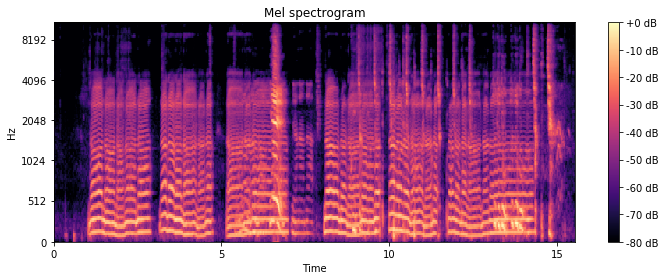

In [12]:
plt.figure(figsize=(10, 4))
librosa.display.specshow(librosa.power_to_db(ps, ref=np.max), y_axis='mel', x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel spectrogram')
plt.tight_layout()

In [27]:
def composer(kind_music_path, model_rnn1_path, model_rnn2_path, kind_rnn_path):
    
    rate1, music1 = read(TEST_WAV)
    music1 = pd.DataFrame(music1[0:800000, :])

    rate2, music2 = read(kind_music_path)
    music2 = pd.DataFrame(music2[0:800000, :])

    # print("x1,x2,y1,y2 data creating....")
    # X1, X2, y1, y2 = create_train_dataset(pd.concat(
    #     [music1.iloc[0: 160000, :], all_music.iloc[0: 160000, :]], axis=0), 3)

    # 시간이 걸림...
    print()
    print("test1,test2 data creating....{}".format(kind_music_path))

    test1, test2 = create_test_data(pd.concat(
        [music1.iloc[160001: 800000, :], music2.iloc[160001: 800000, :]], axis=0), 3)
    

    test1 = test1.reshape((-1,1,3))
    test2 = test2.reshape((-1,1,3))
    
    # loading the saved models
    print("Loading...{},{}".format(model_rnn1_path,model_rnn2_path))
    rnn1 = load_model(model_rnn1_path)
    rnn2 = load_model(model_rnn2_path)

    # making predictions for channel 1 and channel 2
    print("Predicting....{}".format(kind_music_path))  # 바로 됨.

    pred_rnn1 = rnn1.predict(test1)
    pred_rnn2 = rnn2.predict(test2)

    print("{} writing....".format(kind_rnn_path))
    # saving the LSTM predicitons in wav format
    write(kind_rnn_path, rate1, pd.concat([pd.DataFrame(pred_rnn1.astype(
        'int16')), pd.DataFrame(pred_rnn2.astype('int16'))], axis=1).values)

    # sound = AudioSegment.from_wav('music_data/test.wav')
    # play(sound)
    # sleep(2)
    print("{} sound play".format(kind_rnn_path))
    sound = AudioSegment.from_wav(kind_rnn_path)
    play(sound)

In [37]:
composer(JAZZ_WAV_FILE, JAZZ_MODEL_1_FILE, JAZZ_MODEL_2_FILE, JAZZ_RNN_FILE)
composer(EDM_WAV_FILE, EDM_MODEL_1_FILE,EDM_MODEL_2_FILE,EDM_RNN_FILE)
composer(HIPHOP_WAV_FILE, HIPHOP_MODEL_1_FILE, HIPHOP_MODEL_2_FILE,HIHOP_RNN_FILE)
composer(ROCK_WAV_FILE, ROCK_MODEL_1_FILE, ROCK_MODEL_2_FILE,ROCK_RNN_FILE)


test1,test2 data creating....music_data/Jazz/sample.wav
Loading...Brain/rnn1_jazz.h5,Brain/rnn2_jazz.h5
Predicting....music_data/Jazz/sample.wav
music_data/Jazz/jazz_rnn.wav writing....
music_data/Jazz/jazz_rnn.wav sound play

test1,test2 data creating....music_data/EDM/sample.wav
Loading...Brain/rnn1_EDM.h5,Brain/rnn2_EDM.h5
Predicting....music_data/EDM/sample.wav
music_data/EDM/edm_rnn.wav writing....
music_data/EDM/edm_rnn.wav sound play

test1,test2 data creating....music_data/Hiphop/sample.wav
Loading...Brain/rnn1_hiphop.h5,Brain/rnn2_hiphop.h5
Predicting....music_data/Hiphop/sample.wav
music_data/Hiphop/hiphop_rnn.wav writing....
music_data/Hiphop/hiphop_rnn.wav sound play

test1,test2 data creating....music_data/Rock/sample.wav
Loading...Brain/rnn1_Rock.h5,Brain/rnn2_Rock.h5
Predicting....music_data/Rock/sample.wav
music_data/Rock/rock_rnn.wav writing....
music_data/Rock/rock_rnn.wav sound play


In [13]:
# Example of Hip-Hop music
y, sr = librosa.load(JAZZ_RNN_FILE, duration=30)
ps = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
print(ps.shape)
IPython.display.Audio(data=y, rate=sr)

(128, 1138)


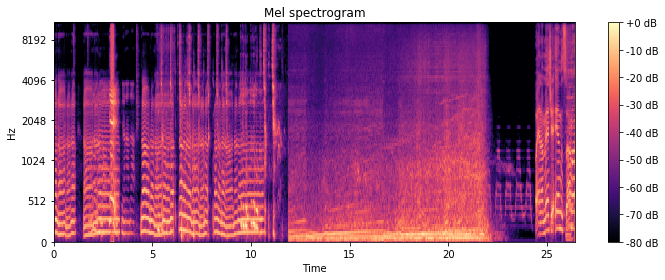

In [20]:
plt.figure(figsize=(10, 4))
librosa.display.specshow(librosa.power_to_db(ps, ref=np.max), y_axis='mel', x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel spectrogram')
plt.tight_layout()

In [18]:
# Example of Hip-Hop music
y, sr = librosa.load(EDM_RNN_FILE, duration=30)
ps = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
print(ps.shape)
IPython.display.Audio(data=y, rate=sr)

(128, 1138)


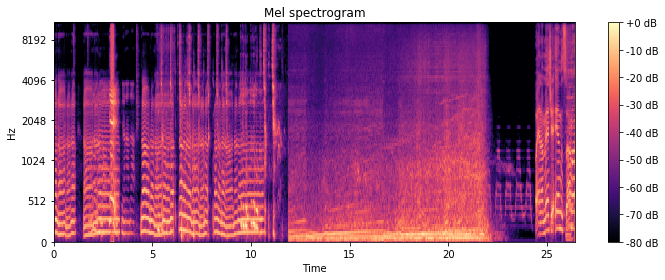

In [19]:
plt.figure(figsize=(10, 4))
librosa.display.specshow(librosa.power_to_db(ps, ref=np.max), y_axis='mel', x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel spectrogram')
plt.tight_layout()

In [16]:
# Example of Hip-Hop music
y, sr = librosa.load(HIHOP_RNN_FILE, duration=30)
ps = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
print(ps.shape)
IPython.display.Audio(data=y, rate=sr)

(128, 1138)


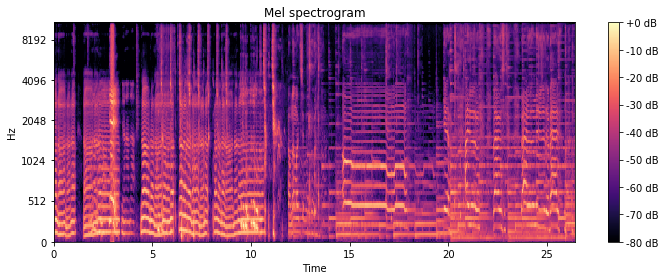

In [17]:
plt.figure(figsize=(10, 4))
librosa.display.specshow(librosa.power_to_db(ps, ref=np.max), y_axis='mel', x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel spectrogram')
plt.tight_layout()

In [14]:
# Example of Hip-Hop music
y, sr = librosa.load(ROCK_RNN_FILE, duration=30)
ps = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
print(ps.shape)
IPython.display.Audio(data=y, rate=sr)

(128, 1138)


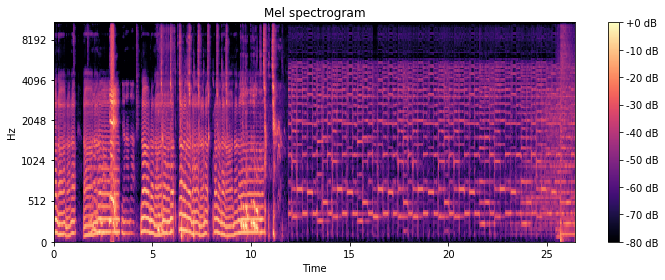

In [15]:
plt.figure(figsize=(10, 4))
librosa.display.specshow(librosa.power_to_db(ps, ref=np.max), y_axis='mel', x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel spectrogram')
plt.tight_layout()